In [36]:
import os
import librosa
import numpy as np
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
SR = 16000
MAX_LEN = 200
N_MELS = 64
BATCH_SIZE = 32
EPOCHS = 25

RAVDESS_PATH = r"C:\Users\Supratim\OneDrive\문서\DLRL Project\ravdess"
TESS_PATH = r"C:\Users\Supratim\OneDrive\문서\DLRL Project\tess\TESS Toronto emotional speech set data"
CREMAD_PATH = r"C:\Users\Supratim\OneDrive\문서\DLRL Project\crema-d\AudioWAV"
IEMOCAP_PATH = r"C:\Users\Supratim\OneDrive\문서\DLRL Project\iemocap\IEMOCAP_full_release"

In [3]:
def extract_logmel(path):
    y, sr = librosa.load(path, sr=SR)
    y, _ = librosa.effects.trim(y)

    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=N_MELS,
        n_fft=2048,
        hop_length=512
    )

    logmel = librosa.power_to_db(mel)

    if logmel.shape[1] < MAX_LEN:
        pad = MAX_LEN - logmel.shape[1]
        logmel = np.pad(logmel, ((0,0),(0,pad)))
    else:
        logmel = logmel[:, :MAX_LEN]

    logmel = (logmel - logmel.mean()) / (logmel.std() + 1e-9)
    return logmel.T


In [4]:
def load_tess(root, X, y):
    VALID_EMOTIONS = ["neutral", "happy", "sad", "angry", "fear", "disgust"]

    for folder in os.listdir(root):
        folder_path = os.path.join(root, folder)
        if not os.path.isdir(folder_path):
            continue
        if not (folder.startswith("OAF_") or folder.startswith("YAF_")):
            continue
        emotion = folder.split("_", 1)[1].lower()
        if "pleasant" in emotion:
            continue
        if emotion not in VALID_EMOTIONS:
            continue
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                path = os.path.join(folder_path, file)
                X.append(extract_logmel(path))
                y.append(emotion)

def load_cremad(root, X, y):
    emo_map = {"ANG":"angry","DIS":"disgust","FEA":"fear","HAP":"happy","SAD":"sad","NEU":"neutral"}
    for file in os.listdir(root):
        if file.endswith(".wav"):
            emo = file.split("_")[2]
            if emo in emo_map:
                X.append(extract_logmel(os.path.join(root, file)))
                y.append(emo_map[emo])

def load_ravdess(root, X, y):
    emo_map = {
        "01":"neutral","03":"happy","04":"sad",
        "05":"angry","06":"fear","07":"disgust"
    }
    for actor in os.listdir(root):
        for file in os.listdir(os.path.join(root, actor)):
            if file.endswith(".wav"):
                code = file.split("-")[2]
                if code in emo_map:
                    X.append(extract_logmel(os.path.join(root, actor, file)))
                    y.append(emo_map[code])

def load_iemocap(root, X, y):
    emo_map = {
        "neu": "neutral",
        "hap": "happy",
        "sad": "sad",
        "ang": "angry",
        "fea": "fear",
        "dis": "disgust"
    }

    for session in os.listdir(root):
        if not session.startswith("Session"):
            continue

        session_path = os.path.join(root, session)

        eval_dir = os.path.join(session_path, "dialog", "EmoEvaluation")
        wav_root = os.path.join(session_path, "sentences", "wav")

        if not os.path.isdir(eval_dir):
            continue

        for eval_file in os.listdir(eval_dir):
            if not eval_file.endswith(".txt"):
                continue

            eval_path = os.path.join(eval_dir, eval_file)

            with open(eval_path, "r", encoding="utf-8") as f:
                for line in f:
                    if not line.startswith("["):
                        continue

                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue

                    wav_id = parts[3]      
                    emo_tag = parts[4]     

                    if emo_tag not in emo_map:
                        continue

                    # sentence folder name
                    sentence_folder = wav_id.rsplit("_", 1)[0]

                    wav_path = os.path.join(
                        wav_root,
                        sentence_folder,
                        wav_id + ".wav"
                    )

                    if not os.path.exists(wav_path):
                        continue

                    X.append(extract_logmel(wav_path))
                    y.append(emo_map[emo_tag])


In [5]:
X, y = [], []

load_ravdess(RAVDESS_PATH, X, y)
load_tess(TESS_PATH, X, y)
load_cremad(CREMAD_PATH, X, y)
load_iemocap(IEMOCAP_PATH, X, y)

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape)
print("Emotion labels:", np.unique(y))

C:\Users\Supratim\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Supratim\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Supratim\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Dataset shape: (15430, 200, 64)
Emotion labels: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']


In [6]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))


In [7]:
inp = Input(shape=(MAX_LEN, N_MELS))
x = LSTM(128, return_sequences=True)(inp)
x = Dropout(0.3)(x)
x = LSTM(64)(x)
x = Dense(64, activation="relu")(x)
out = Dense(len(le.classes_), activation="softmax")(x)

model = Model(inp, out)
model.compile(
    optimizer=Adam(0.0003),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,774 (596.77 KB)

 Trainable params: 152,774 (596.77 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[EarlyStopping(patience=6, restore_best_weights=True)]
)

Epoch 1/25
348/348 ━━━━━━━━━━━━━━━━━━━━ 229s 658ms/step - accuracy: 0.2376 - loss: 1.6831 - val_accuracy: 0.2794 - val_loss: 1.6732
Epoch 3/25
348/348 ━━━━━━━━━━━━━━━━━━━━ 214s 613ms/step - accuracy: 0.2852 - loss: 1.6130 - val_accuracy: 0.2802 - val_loss: 1.6143
Epoch 4/25
348/348 ━━━━━━━━━━━━━━━━━━━━ 232s 667ms/step - accuracy: 0.2984 - loss: 1.5665 - val_accuracy: 0.3287 - val_loss: 1.5901
Epoch 5/25
348/348 ━━━━━━━━━━━━━━━━━━━━ 234s 588ms/step - accuracy: 0.3221 - loss: 1.5534 - val_accuracy: 0.3336 - val_loss: 1.5505
Epoch 6/25
348/348 ━━━━━━━━━━━━━━━━━━━━ 267s 601ms/step - accuracy: 0.3285 - loss: 1.5417 - val_accuracy: 0.3166 - val_loss: 1.5559
Epoch 7/25
348/348 ━━━━━━━━━━━━━━━━━━━━ 195s 559ms/step - accuracy: 0.3677 - loss: 1.4720 - val_accuracy: 0.3919 - val_loss: 1.4643
Epoch 8/25
348/348 ━━━━━━━━━━━━━━━━━━━━ 186s 535ms/step - accuracy: 0.3909 - loss: 1.4514 - val_accuracy: 0.4065 - val_loss: 1.4218
Epoch 9/25
348/348 ━━━━━━━━━━━━━━━━━━━━ 184s 528ms/step - accuracy: 0.4382 -

In [10]:
model.save("ser_combined_lstm.h5")
pickle.dump(le, open("label_encoder.pkl","wb"))

In [24]:
model = load_model("ser_combined_lstm.h5")

y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)

print("\nCLASSIFICATION REPORT\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


97/97 ━━━━━━━━━━━━━━━━━━━━ 33s 334ms/step

CLASSIFICATION REPORT

              precision    recall  f1-score   support

       angry       0.79      0.67      0.73       593
     disgust       0.38      0.69      0.49       373
        fear       0.76      0.20      0.32       381
       happy       0.48      0.47      0.47       492
     neutral       0.56      0.68      0.62       658
         sad       0.67      0.59      0.63       589

    accuracy                           0.57      3086
   macro avg       0.61      0.55      0.54      3086
weighted avg       0.62      0.57      0.57      3086



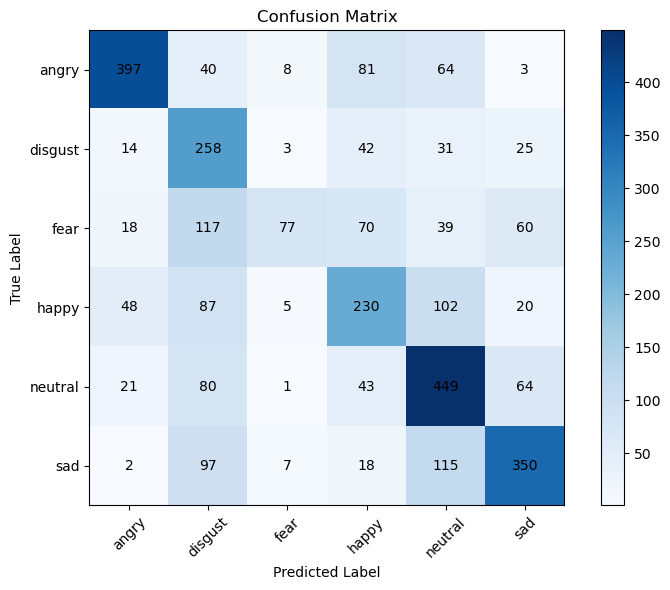

In [38]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

ticks = np.arange(len(le.classes_))
plt.xticks(ticks, le.classes_, rotation=45)
plt.yticks(ticks, le.classes_)            

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], ha="center", va="center")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()
